In [1]:
#Data importation and storage packages
using CSV, DataFrames

#Data processing packages
using LinearAlgebra: norm

#Visualization packages
using Makie, CairoMakie
Makie.inline!(true); #make sure plots are shown in Jupyter notebook.

### 0. Data importation

In [2]:
dataA = CSV.File("HW5_data//dataA.csv") |> Tables.matrix;
dataB = CSV.File("HW5_data//dataB.csv") |> Tables.matrix;

@show nA = size(dataA);
@show nB = size(dataB);

nA = size(dataA) = (1200, 3)
nB = size(dataB) = (1200, 3)


#### functions for x-y grid generation

In [3]:
"""
function getGrid(xs::Vector{Float64}, ys::Vector{Float64})
Generate a vector of x and y positions of grid spacing `xs` and `ys`
"""
function getGrid(xs::Vector{Float64}, ys::Vector{Float64})
    lx, ly = length(xs), length(ys)
    lxly = lx*ly
    # res = Array{Base.promote_eltype(xs, ys), 2}(undef, lxly, 2)
    output = zeros(lxly,2);
    ind = 1
    while ind<=lxly
        @inbounds for x in xs
            output[ind] = x
            ind += 1
        end
    end
    for y in ys
        @inbounds for i=1:lx
        output[ind] = y
        ind += 1
        end
    end
    return output
end

#for performance purposes, can be ignored.
function getGrid2(xs::Vector{Float64}, ys::Vector{Float64})
    lx, ly = length(xs), length(ys)
    lxly = lx * ly
    output = zeros(lxly, 2)  # Initialize a matrix to hold pairs of (x, y)
    ind = 1
    for x in xs
        for y in ys
            output[ind, 1] = x  # Store x value
            output[ind, 2] = y  # Store y value
            ind += 1
        end
    end
    return output
end

getGrid2 (generic function with 1 method)

In [4]:
#ranges of the betas.
β1 = collect(-25:0.1:75);
β2 = collect(-40:0.1:40); 
β = getGrid(β1, β2);
println(size(β));

#slicing the data based on the given variables
yA  = dataA[:,3];
xA1 = dataA[:,1];
xA2 = dataA[:,2];
yB  = dataB[:,3];
xB1 = dataB[:,1];
xB2 = dataB[:,2];

"""
Calculate loss at a point β
"""
function calculate_loss(β; 
    yA = yA, yB = yB, 
    xA1 = xA1, xA2 = xA2, 
    xB1 = xB1, xB2 = xB2)
    
    loss_A = (yA .- β[1] * xA1 - β[2] * xA2) .^ 2;
    loss_B = (yB .- β[1] * xB1 - β[2] * xB2) .^ 2;
    loss_All = sum(min.(loss_A, loss_B));
    return loss_All
end

lossAll = zeros(size(β,1),1);
for i = 1:size(β,1)
    lossAll[i] = calculate_loss(β[i,:]);
end
lossAll = lossAll/(2*nA[1]);

(801801, 2)


# Part A: Problem Visualization

In [5]:
#Verifying the sizes and ranges of the parameters
@show size(β[:,1])
@show size(β[:,2])
@show size(lossAll)
@show maximum(lossAll)
@show minimum(lossAll)

size(β[:, 1]) = (801801,)
size(β[:, 2]) = (801801,)
size(lossAll) = (801801, 1)
maximum(lossAll) = 41799.348424973934
minimum(lossAll) = 5.421416459079418


5.421416459079418

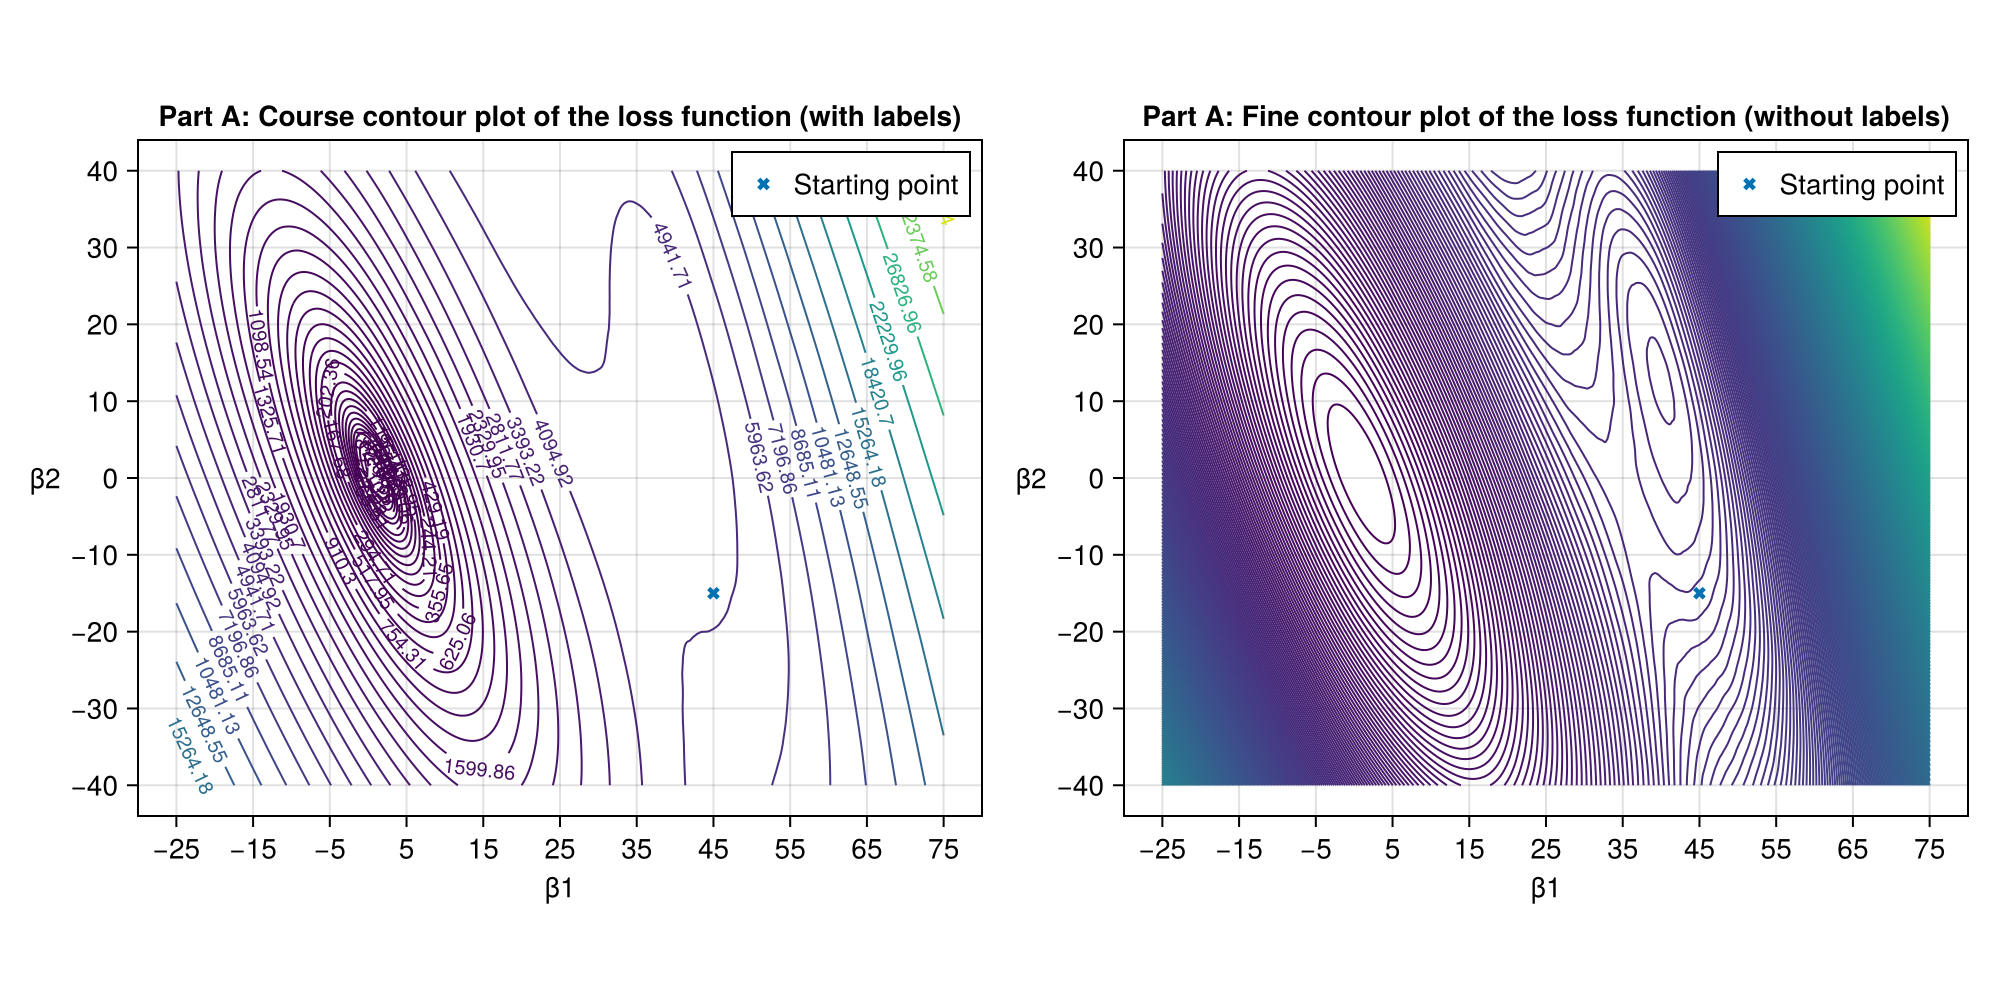

In [6]:
f_result_A = Figure(size = (1000,500)); 

ax_with_labels = Axis(f_result_A[1,1], title = "Part A: Course contour plot of the loss function (with labels)", xlabel = "β1" , ylabel = "β2", aspect = DataAspect(),
                yticks = -40:10:40, xticks = -25:10:75, ylabelrotation = 0)

ax_without_labels = Axis(f_result_A[1,2], title = "Part A: Fine contour plot of the loss function (without labels)", xlabel = "β1" , ylabel = "β2", aspect = DataAspect(),
                yticks = -40:10:40, xticks = -25:10:75, ylabelrotation = 0)

c_with_labels = contour!(ax_with_labels,β[:,1], β[:,2], lossAll[:,1], levels = 10.0.^range(1, 5; length=50), labels = true)
s_with_labels = scatter!(ax_with_labels, 45, -15, label = "Starting point", marker = :x)
axislegend(ax_with_labels)

c_wihtout_labels = contour!(ax_without_labels,β[:,1], β[:,2], lossAll[:,1], levels = 0:1e2:4e5, labels = false)
s_wihtout_labels = scatter!(ax_without_labels, 45, -15, label = "Starting point", marker = :x)
axislegend(ax_without_labels)

display(f_result_A);

From the plot, we can see that the shape is non-convex as there are 2 local minima. This means, for an unconstrained optimization, the result might be sub-optimal, especially with the given starting point, we can see the potential of it descent into the local minima.

# Part B: Gradient descent method

In [7]:
#the learning rate
α = 0.01;
β0 = [45, -15];
βk = β0 ; #initializing
β_container_001 = Vector{Vector{Float64}}();
change = 1;
loss_old = 1;
while change > 1e-5
    #keep track of β
    push!(β_container_001, βk)
    
    loss_set_A = (yA .- βk[1]*xA1 .- βk[2]*xA2) .^ 2;
    loss_set_B = (yB .- βk[1]*xB1 .- βk[2]*xB2) .^ 2;
    is_set_A_min = loss_set_A .< loss_set_B;
    
    #gradient
    grad_set_A = 2 * (yA .- βk[1] * xA1 - βk[2] * xA2) .* hcat(-xA1, -xA2);
    grad_set_B = 2 * (yB .- βk[1] * xB1 - βk[2] * xB2) .* hcat(-xB1, -xB2);

    dk = -sum( ( is_set_A_min' * grad_set_A .+ .!is_set_A_min' * grad_set_B), dims = 1 )/(2*nA[1]);
    βk = βk + α*vec(dk)

    #calculate the new loss
    loss_new = calculate_loss(βk)
    change = abs(loss_new - loss_old)/loss_old
    loss_old = loss_new
end   
loss_001 = loss_old

1.076079371637502e7

In [8]:
#the learning rate
α = 0.1;
β0 = [45, -15];
βk = β0 ; #initializing
β_container_01 = Vector{Vector{Float64}}();
change = 1;
loss_old = 1;
count = 0;
max_iteration = 10000
while change > 1e-4 && count < max_iteration
    count = count + 1
    #keep track of β
    push!(β_container_01, βk)

    #check condition to use gradient from A or B terms.
    loss_set_A = (yA .- βk[1]*xA1 .- βk[2]*xA2) .^ 2;
    loss_set_B = (yB .- βk[1]*xB1 .- βk[2]*xB2) .^ 2;
    is_set_A_min = loss_set_A .< loss_set_B;
    
    #gradient
    grad_set_A = 2 * (yA .- βk[1] * xA1 - βk[2] * xA2) .* hcat(-xA1, -xA2);
    grad_set_B = 2 * (yB .- βk[1] * xB1 - βk[2] * xB2) .* hcat(-xB1, -xB2);

    dk = -sum( ( is_set_A_min' * grad_set_A .+ .!is_set_A_min' * grad_set_B), dims = 1 )/(2*nA[1]);
    βk = βk + α*vec(dk)

    #calculate the new loss
    loss_new = calculate_loss(βk)
    change = abs(loss_new - loss_old)/loss_old
    loss_old = loss_new
end   
loss_01 = loss_old

3.4502071762328995e6

In [9]:
println(">α = 0.01 Loss: $(loss_001))")
println(">α = 0.01 #Iterations: $(size(β_container_001))")
println(">α = 0.01 end point $(β_container_001[end])")
println("###")
println(">α = 0.1 Loss: $(loss_01))")
println(">α = 0.1 #Iterations: $(size(β_container_01))")
println(">α = 0.1 end point $(β_container_01[end])")

>α = 0.01 Loss: 1.076079371637502e7)
>α = 0.01 #Iterations: (262,)
>α = 0.01 end point [40.3335697664001, 9.982301629260347]
###
>α = 0.1 Loss: 3.4502071762328995e6)
>α = 0.1 #Iterations: (10000,)
>α = 0.1 end point [13.895543103524533, 5.621095554726081]


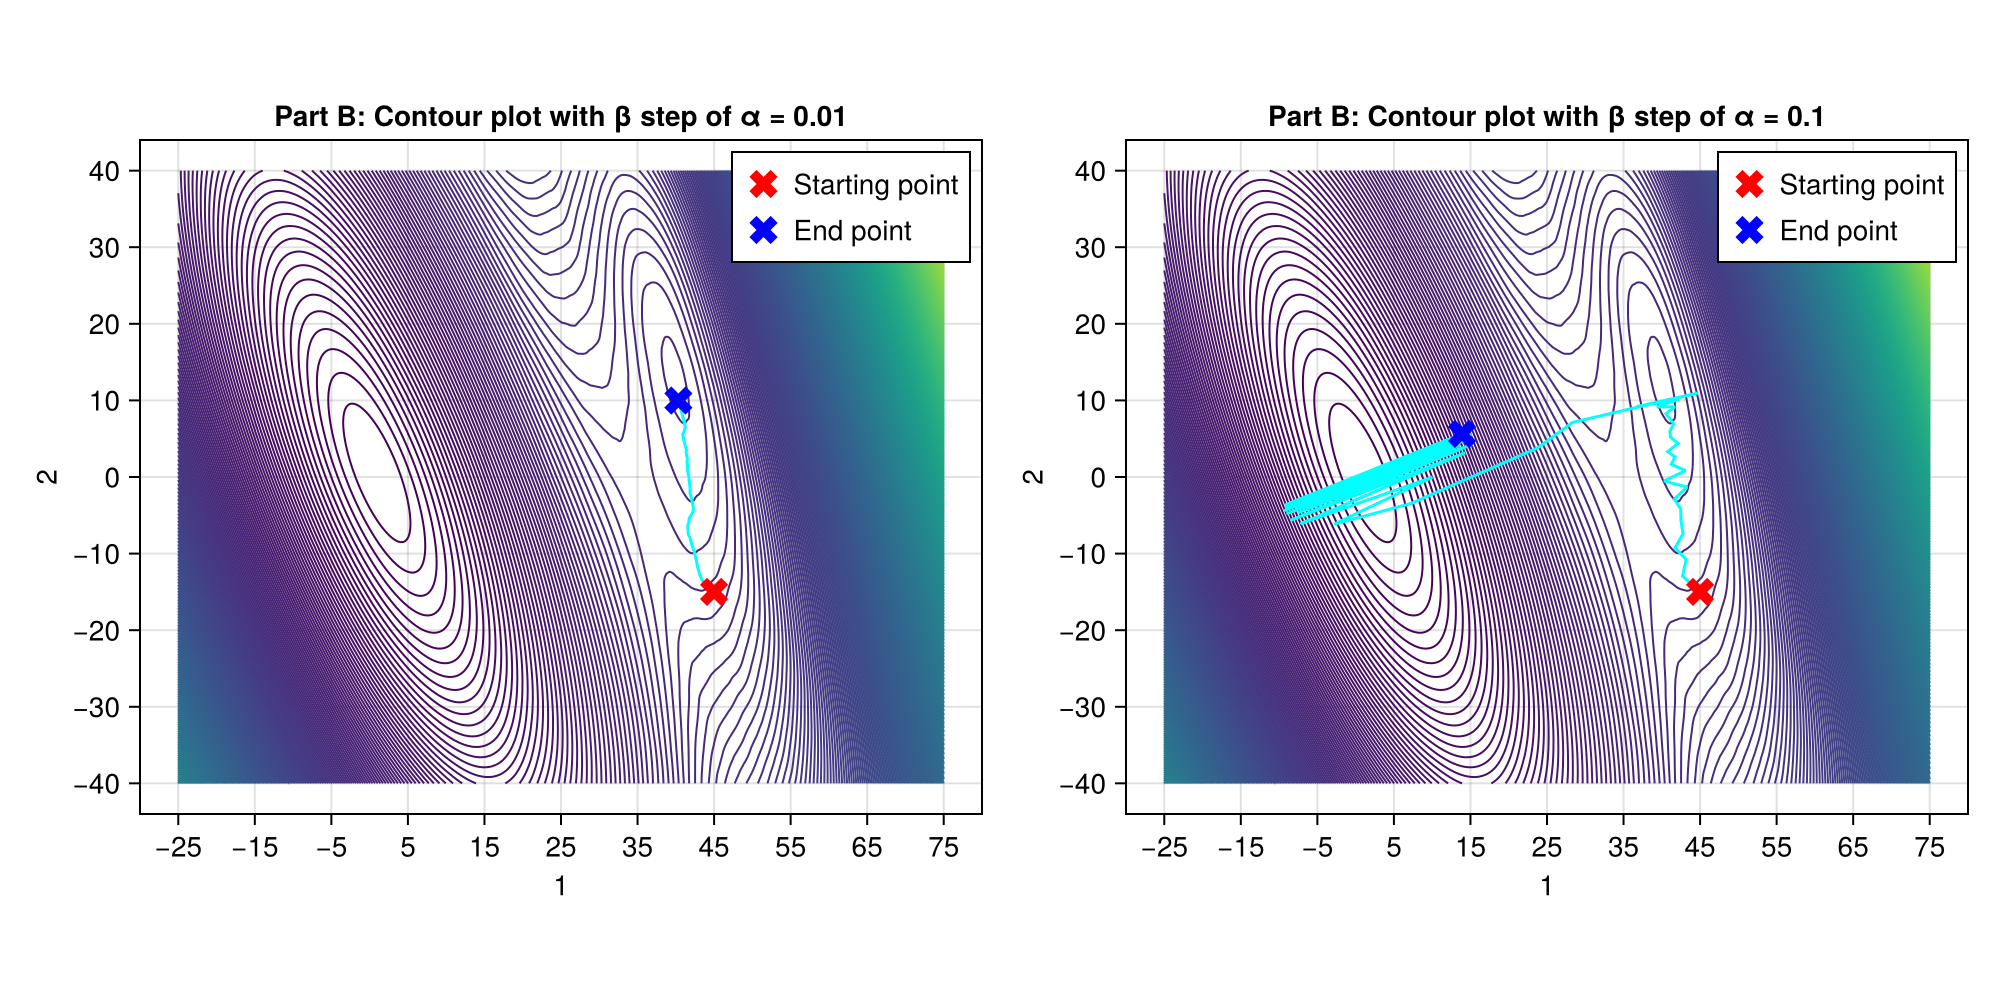

In [10]:
f_result_B = Figure(size = (1000,500)); 

ax_α_001 = Axis(f_result_B[1,1], title = "Part B: Contour plot with β step of α = 0.01", xlabel = "1" , ylabel = "2", aspect = DataAspect(),
yticks = -40:10:40, xticks = -25:10:75)

ax_α_01 = Axis(f_result_B[1,2], title = "Part B: Contour plot with β step of α = 0.1", xlabel = "1" , ylabel = "2", aspect = DataAspect(),
yticks = -40:10:40, xticks = -25:10:75)

contour_001 = contour!(ax_α_001,β[:,1], β[:,2], lossAll[:,1], levels = 0:1e2:5e4, labels = false)
lines_steps_001 = lines!(ax_α_001, Point2f.(β_container_001), color = "#00FFFF")
scatter_start_001 = scatter!(ax_α_001, 45, -15, label = "Starting point", marker = :x, markersize = 20, color = :red)
scatter_end_001 = scatter!(ax_α_001, β_container_001[end][1],β_container_001[end][2], label = "End point", marker = :x, markersize = 20, color = :blue)
axislegend(ax_α_001)

contour_01 = contour!(ax_α_01,β[:,1], β[:,2], lossAll[:,1], levels = 0:1e2:5e4, labels = false)
lines_steps_01 = lines!(ax_α_01, Point2f.(β_container_01), color = "#00FFFF")
scatter_start_01 = scatter!(ax_α_01, 45, -15, label = "Starting point", marker = :x, markersize = 20, color = :red)
scatter_end_01 = scatter!(ax_α_01, β_container_01[end][1],β_container_01[end][2], label = "End point", marker = :x, markersize = 20, color = :blue)
axislegend(ax_α_01)

display(f_result_B);

For the step size = 0.001, we can see that the value descent to the local minimum as we expected. It take X iterations to reach there, which is a lot compared to the larger step size. This is reasonable as we take a tiny step.As for the larger step size, we can see that it can escape the local minima, however, the size was too big for it to descent into the global minima, resulting in a bouncing back and forth betwen the global minimum.

## Part C: Stochastic Gradient Descent Method

In [11]:
#Using StatsBase to randomly sample the indices
using StatsBase: sample
#Using Random to set seed.
import Random

In [12]:
function stochasticGradientDescent(seed_value::Int64; 
        yA = yA, yB = yB, 
        xA1 = xA1, xA2 = xA2, 
        xB1 = xB1, xB2 = xB2,
        batch_size::Int64 = 10, β0::Vector{Int64} = [45, -15],
        α::Float64 = 0.01, 
        max_iteration = 10000)
    
    Random.seed!(seed_value)#the learning rate
    βk = β0 ; #initializing
    β_container = Vector{Vector{Float64}}();
    change = 1;
    loss_old = 1;
    count = 0;

    while change > 1e-6 && count < max_iteration
        count = count + 1
        #keep track of β
        push!(β_container, βk)
    
        #select `batch_size` indices
        random_idx = sample(1:1200, batch_size; replace=false)
        
        #check condition to use gradient from A or B terms.
        loss_set_A = (yA[random_idx] .- βk[1]*xA1[random_idx] .- βk[2]*xA2[random_idx]) .^ 2;
        loss_set_B = (yB[random_idx] .- βk[1]*xB1[random_idx] .- βk[2]*xB2[random_idx]) .^ 2;
        is_set_A_min = loss_set_A .< loss_set_B;
        
        #gradient
        grad_set_A = 2 * (yA[random_idx] .- βk[1] * xA1[random_idx] - βk[2] * xA2[random_idx]) .* hcat(-xA1[random_idx], -xA2[random_idx]);
        grad_set_B = 2 * (yB[random_idx] .- βk[1] * xB1[random_idx] - βk[2] * xB2[random_idx]) .* hcat(-xB1[random_idx], -xB2[random_idx]);
    
        dk = -sum( ( is_set_A_min' * grad_set_A .+ .!is_set_A_min' * grad_set_B), dims = 1 )/(2*batch_size);
        βk = βk + α*vec(dk)
    
        #calculate the new loss
        loss_new = calculate_loss(βk)
        change = abs(loss_new - loss_old)/loss_old
        loss_old = loss_new

        #Maximum iteration exit condition
        if count == max_iteration
            println("Maximum number of iteration reached, exiting...")
            break
        end
        
    end
    return β_container, loss_old
end

stochasticGradientDescent (generic function with 1 method)

In [13]:
β_container_1, loss_1 = stochasticGradientDescent(1234, batch_size = 10); 
β_container_2, loss_2 = stochasticGradientDescent(4321, batch_size = 10); 
β_container_3, loss_3 = stochasticGradientDescent(1557, batch_size = 10);

Maximum number of iteration reached, exiting...


In [14]:
println(">1 Loss: $(loss_1))")
println(">1 #Iterations: $(size(β_container_1))")
println(">1 end point $(β_container_1[end])")
println("###")
println(">2 Loss: $(loss_2))")
println(">2 #Iterations: $(size(β_container_2))")
println(">2 end point $(β_container_2[end])")
println("###")
println(">3 Loss: $(loss_3))")
println(">3 #Iterations: $(size(β_container_3))")
println(">3 end point $(β_container_3[end])")

>1 Loss: 13021.974448133671)
>1 #Iterations: (2034,)
>1 end point [0.917541091024257, 0.5051811855264643]
###
>2 Loss: 13065.110913176672)
>2 #Iterations: (361,)
>2 end point [1.0149589716653926, 0.3924428017105104]
###
>3 Loss: 13400.322181241678)
>3 #Iterations: (10000,)
>3 end point [1.0780560001463655, 0.5058953152510528]


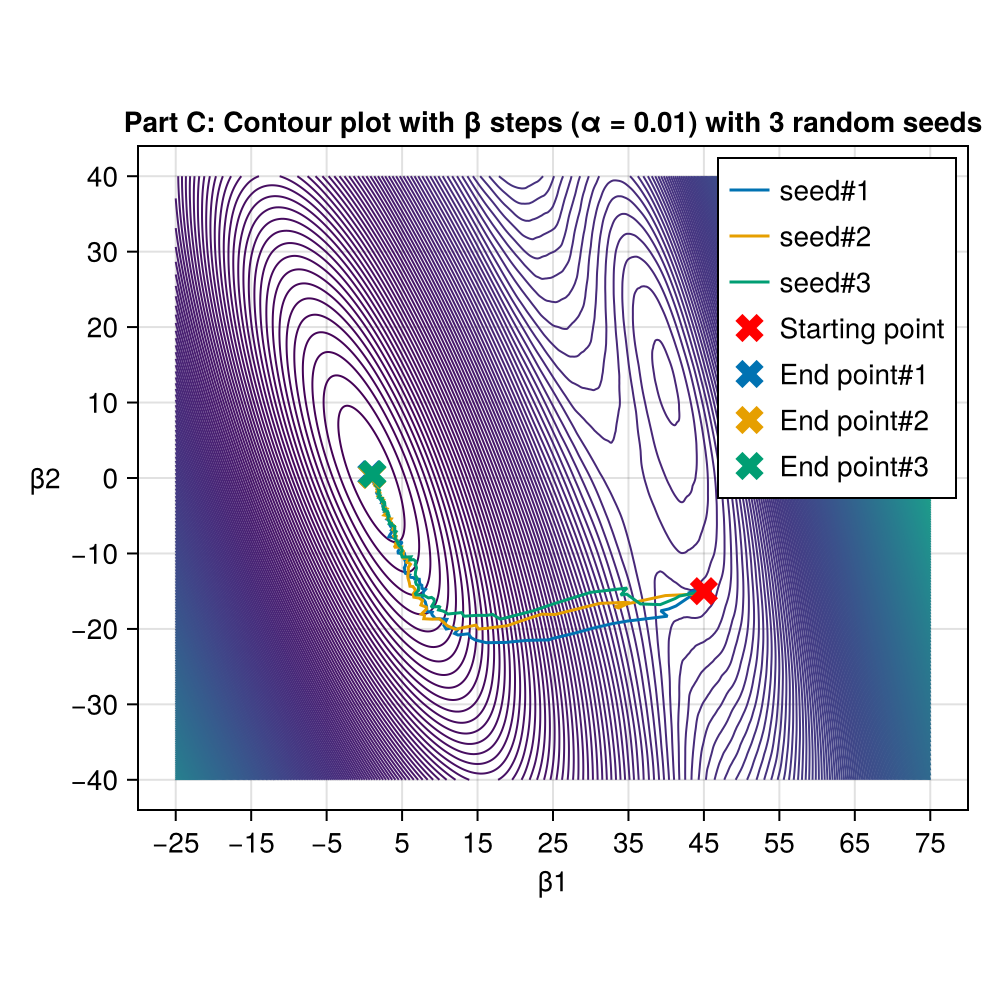

In [15]:
f_result_C = Figure(size = (500,500)); 

ax_part_c = Axis(f_result_C[1,1], title = "Part C: Contour plot with β steps (α = 0.01) with 3 random seeds", xlabel = "β1" , ylabel = "β2", aspect = DataAspect(),
yticks = -40:10:40, xticks = -25:10:75, ylabelrotation = 0)

contour_part_c = contour!(ax_part_c,β[:,1], β[:,2], lossAll[:,1], levels = 0:1e2:5e4, labels = false)

lines_steps_1 = lines!(ax_part_c, Point2f.(β_container_1), label = "seed#1")
lines_steps_2 = lines!(ax_part_c, Point2f.(β_container_2), label = "seed#2")
lines_steps_3 = lines!(ax_part_c, Point2f.(β_container_3), label = "seed#3")


scatter_start = scatter!(ax_part_c, 45, -15, label = "Starting point", marker = :x, markersize = 20, color = :red)
scatter_end_1 = scatter!(ax_part_c, β_container_1[end][1],β_container_1[end][2], label = "End point#1", marker = :x, markersize = 20)
scatter_end_2 = scatter!(ax_part_c, β_container_2[end][1],β_container_2[end][2], label = "End point#2", marker = :x, markersize = 20)
scatter_end_3 = scatter!(ax_part_c, β_container_3[end][1],β_container_3[end][2], label = "End point#3", marker = :x, markersize = 20)

axislegend(ax_part_c)
display(f_result_C);

In [16]:
save("Part_A.png", f_result_A);
save("Part_B.png", f_result_B);
save("Part_C.png", f_result_C);